In [ ]:
import pandas as pd
# from matplotlib import pyplot
import numpy as np
import seaborn as sns
import math
import datetime
import pickle
import joblib
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

model_rfr_ftr = joblib.load('savemodel_rfr_ftr.sav')
# model_rfr_hpo = joblib.load('savemodel_rfr_ftr_hpo.sav')
model_rfr_hpov = joblib.load('savemodel_rfr_ftr_hpov.sav')
# model_rft = joblib.load('savemodel_rf.sav')


model_etr = joblib.load('savemodel_etr.sav')
model_etr_hpov = joblib.load('savemodel_etr_hpov.sav')

model_dtr_ftr = joblib.load('savemodel_dtr_ftr.sav')
model_dtr_hpov = joblib.load('savemodel_dtr_hpov.sav')


model_mlr_ftr = joblib.load('savemodel_mlr_ftr.sav')

dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
dfmain = dfmain[dfmain['LAT'] > 55.04 ]

dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
dfpre = dfpre[dfpre['LAT'] > 55.04 ]

In [ ]:
dfmain = dfmain.drop(['Wind Speed','Current Speed'],axis=1)

In [ ]:
dfpre = dfpre.drop(dfpre.columns[[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,26]],axis=1)
dfpre = dfpre.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 
dfpre.head(n=5)

In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(dfpre)

In [ ]:
x_pre = imputer.transform(dfpre)

In [ ]:
dfpre = pd.DataFrame(x_pre, columns=dfpre.columns, index=dfpre.index)

In [ ]:
dfpre["Current Speed"] = np.sqrt(dfpre["eastcurrent"]**2 + dfpre["northcurrent"]**2)
dfpre["Wind Speed"] = np.sqrt(dfpre["eastwind"]**2 + dfpre["northwind"]**2)

In [ ]:
dfpre.describe()

In [ ]:
# dfpre["True North Wind Direction"] =  180 +  np.rad2deg(np.arctan((dfpre["eastwind"])/(dfpre["northwind"])))

condwind = [(dfpre['eastwind']>0) & (dfpre['northwind']<0),
            (dfpre['eastwind']<0) & (dfpre['northwind']>0),
            (dfpre['eastwind']>0) & (dfpre['northwind']>0)]

choicewind = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"])))]

dfpre["True North Wind Direction"] = np.select(condwind, choicewind, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))))

# dfpre["True North Wind Direction"] = np.where(dfpre["True North Wind Direction"] > 0, 180 + dfpre["True North Wind Direction"] , 180 - dfpre["True North Wind Direction"])

# if dfpre["True North Wind Direction"]<0:
#     dfpre["True North Wind Direction"] = 180 - dfpre["True North Wind Direction"]
# elif dfpre["True North Wind Direction"]>0:
#     dfpre["True North Wind Direction"] = 180 - dfpre["True North Wind Direction"]

In [ ]:
# dfpre["True North Current Direction"] = np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))

# dfpre["True North Current Direction"] = np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))


# 
condcurr = [(dfpre['eastcurrent']<0) & (dfpre['northcurrent']>0),
            (dfpre['eastcurrent']>0) & (dfpre['northcurrent']<0),
            (dfpre['eastcurrent']<0) & (dfpre['northcurrent']<0)]

choicecurr = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"])))]

dfpre["True North Current Direction"] = np.select(condcurr, choicecurr, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))))

In [ ]:
dfpre = dfpre.drop(['eastwind','northwind','eastcurrent','northcurrent','sog','cog'],axis=1)

In [ ]:
df = pd.concat([dfmain,dfpre],axis=1)
df.head()

In [ ]:
# SOG threshold according to Abebe
df = df[df['SOG'] > 5 ]

In [ ]:
# Exclude data for the month of June to check the model's forecasting performance 

dfdate6 = df[df['Time'].dt.strftime('%Y-%m') == '2021-06']
df = df[df['Time'].dt.strftime('%Y-%m') != '2021-06']

# Extract information of a journey from a single day

koege_dep = df[df['Time'].dt.strftime('%Y-%m-%d %H:%M:%S') == '2021-05-31 23:00:00']
koege_arr = dfdate6[dfdate6['Time'].dt.strftime('%Y-%m-%d') == '2021-06-01']

# Drop the departure time for next trip

koege_arr2 = koege_arr.drop(koege_arr.index[14])

# To gain information for a single trip from Koege to Ronne

ronne_arr = koege_arr.drop(koege_arr.index[4:15])

dfday6 = pd.concat([koege_dep,koege_arr2])
dfone6 = pd.concat([koege_dep,ronne_arr])

# # For Qgis Single Journey
# dfday6.to_csv("AIS_01_06_21_koegeronne.csv")

In [ ]:
df.info()

Add test data for 3 months into validation data

In [ ]:
# Data Splitting

from sklearn.model_selection import train_test_split

# Dropping some feature can be done here to (possibly) increase the model's performance 
x_train,x_test,y_train,y_test = train_test_split(df.drop(['SOG']
                                                                 ,axis=1)
                                                                ,df.SOG,test_size=0.2,random_state=42)

In [ ]:
df_test = pd.concat([x_test,y_test],axis=1)

In [ ]:
# Extract three months of data from the test datasets

dfdate7 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-07']
dfdate8 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-08']
dfdate9 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-09']

# Concatenate 3 months data into df_ship

df_months3 = pd.concat([dfdate7,dfdate8,dfdate9])

In [ ]:
df_ship = df_months3.drop(['Unnamed: 0','LON','LAT','Time','Air density above oceans',
                    'Surface pressure','Width','Length'],axis=1)
df_ship.head(n=5)

In [ ]:
df_ship2 = df_ship.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [ ]:
df_ship2 = df_ship2[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

In [ ]:
df_ship2 = df_ship2.drop(['waveheight','swellheight','windwaveheight',
                        'windwaveperiod','swellperiod',
                        'truewindwavedir','trueswelldir',
                        'truecurrentdir','truewinddir'],axis=1)

In [ ]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(df_ship2)


In [ ]:
X = imputer.transform(df_ship2)

In [ ]:
df_ship2tr = pd.DataFrame(X, columns=df_ship2.columns, index=df_ship2.index)

In [ ]:
x_months3 = df_ship2tr.drop(['sog'],axis=1)
y_months3 = df_ship2tr.sog

In [ ]:
print("Amount of the test dataset is:",len(x_months3))

Special Section

In [ ]:
# # Check model performance for one trip
# # PLEASE COMMMENT WHEN DONE !!!

# dfdate6 = dfone6

Exporting File

In [ ]:
# df.to_csv('June_update.csv')

Measure performance in one month

In [ ]:
dfdate6 = dfdate6.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)
dfdate6.head(n=5)

In [ ]:
dfdate6= dfdate6.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [ ]:
# Rearrange column to match model 
# Also dropping the features as described in the main script

dfdate6 = dfdate6[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]


# dfdate6 = dfdate6[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

In [ ]:
stats2 = dfdate6['curspeed'].value_counts()

In [ ]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)


In [ ]:
imputer.fit(dfdate6)

In [ ]:
xdate = imputer.transform(dfdate6)

In [ ]:
dfdate6tr = pd.DataFrame(xdate, columns=dfdate6.columns, index=dfdate6.index)

In [ ]:
# x_date = dfdate6tr.drop(['sog','truenorthcurrentdir','truenorthwinddir'],axis=1)
# y_date = dfdate6tr.sog

x_date = dfdate6tr.drop(['sog','truecurrentdir','truewinddir'],axis=1)
y_date = dfdate6tr.sog

In [ ]:
print(f"Amount of the test dataset is {len(x_date)}")

In [ ]:
dfdate6.describe()

Reverse Modelling Test 

Concatenate test and validation data 

In [ ]:
x_date_c = pd.concat([x_date,x_months3])
y_date_c = pd.concat([y_date,y_months3])

In [ ]:
def evaluate(model, features_x, labels_y):
    from sklearn.model_selection import cross_val_score

    score_r2 = cross_val_score(model,features_x,labels_y,
                           scoring='r2',cv=10)
    rsquared = score_r2.mean()

    score_expVar = cross_val_score(model,features_x,labels_y,
                           scoring='explained_variance',cv=10)
    expVar = score_expVar.mean()

    score_MAE = cross_val_score(model,features_x,labels_y,
                           scoring='neg_mean_absolute_error',cv=10)
    MAE = -score_MAE.mean()

    score_MAD = cross_val_score(model,features_x,labels_y,
                           scoring='neg_median_absolute_error',cv=10)
    MAD = -score_MAD.mean()

    score_RMSE = cross_val_score(model,features_x,labels_y,
                           scoring='neg_root_mean_squared_error',cv=10)
    RMSE = -score_RMSE.mean()

    print(f"Model Performance of {model}")
    print(f"R^2: {rsquared:0.4f}")
    print(f"explained Variance = {expVar:0.4f}")
    print(f"MAE = {MAE:0.4f}")
    print(f"RMSE = {RMSE:0.4f}")
    print(f"MAD = {MAD:0.4f}\n")

    return score_r2,score_expVar,score_MAE,score_MAD,score_RMSE    

RFR evaluation

In [ ]:
r2_rf,expVar_rf,MAE_rf,RMSE_rf,MAD_rf = evaluate(model_rfr_ftr,x_date,y_date)

RFR evaluation of June + 3 Months data

In [ ]:
r2_rfc,expVar_rfc,MAE_rfc,RMSE_rfc,MAD_rfc = evaluate(model_rfr_ftr,x_date_c,y_date_c)

In [ ]:
r2_rfo,expVar_rfo,MAE_rfo,RMSE_rfo,MAD_rfo = evaluate(model_rfr_hpov,x_date,y_date)

In [ ]:
r2_et,expVar_et,MAE_et,RMSE_et,MAD_et = evaluate(model_etr,x_date,y_date)

In [ ]:
r2_eto,expVar_eto,MAE_eto,RMSE_eto,MAD_eto = evaluate(model_etr_hpov,x_date,y_date)

In [ ]:
r2_dt,expVar_dt,MAE_dt,RMSE_dt,MAD_dt = evaluate(model_dtr_ftr,x_date,y_date)

In [ ]:
r2_dto,expVar_dto,MAE_dto,RMSE_dto,MAD_dto = evaluate(model_dtr_hpov,x_date,y_date)

In [ ]:
r2_mlr,expVar_mlr,MAE_mlr,RMSE_mlr,MAD_mlr = evaluate(model_mlr_ftr,x_date,y_date)

In [126]:
# fit a y = mx + c for the predicted vs actual  

from numpy import arange
from scipy.optimize import curve_fit

# plt.figure(figsize=(5,5))

# define the true objective function
def objective(x, a, b ):
	return a * x + b

def label_predict(model,test_features):
    predictions = model.predict(test_features)
    return predictions

def pred_plot(model,modelname,test_feature,test_label):
    
    plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
    from sklearn.linear_model import LinearRegression
    predict = label_predict(model,test_feature)

    from sklearn.metrics import r2_score

    print(r2_score(test_label, predict))

    # choose the input and output variables
    x, y = test_label, predict

    reg = LinearRegression().fit(x.values.reshape(-1,1) , y)
    b = reg.intercept_
    m = reg.coef_[0]
    plt.axline(xy1=(0, b), slope=m, label=rf'$y = {m:.1f}x {b:+.1f}$',color = 'r', ls ='--')

    # curve fit
    popt, _ = curve_fit(objective, x, y)

    # summarize the parameter values
    a, b = popt
    print('y = %.1f * x + %.1f' % (a, b ))

    # plot input vs output
    
    plt.scatter(x, y,edgecolors='black')
    
    # define a sequence of inputs between the smallest and largest known inputs
    
    x_line = arange(min(x), max(x), 1)
        
    # calculate the output for the range
    
    y_line = objective(x_line, a, b)
    
    # create a line plot for the mapping function
    
    # plt.plot(x_line, y_line, color='red')
    plt.xlabel(r'Predicted SOG [$m/s$]', fontsize=13)
    plt.ylabel(r'Actual SOG [$m/s$]', fontsize=13)
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.title(rf"{modelname}", fontsize=14)
    plt.xlim(0,25)
    plt.ylim(0,25)
    plt.legend()



0.7740099243031933
y = 0.86928 * x + 1.85310
0.8257225917278368
y = 0.85924 * x + 2.06399


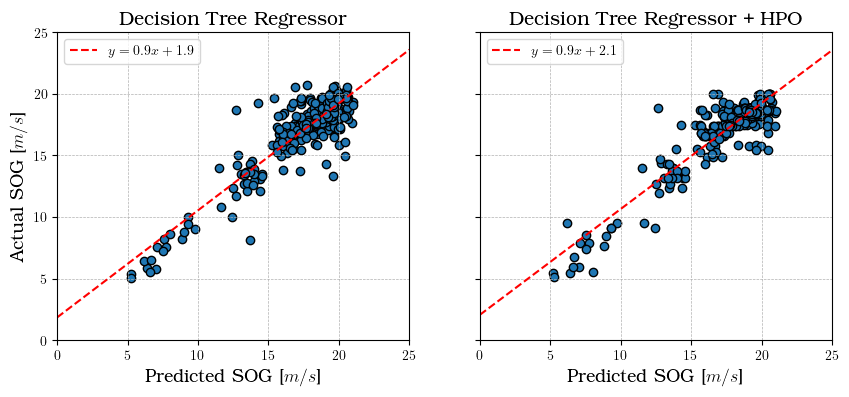

In [127]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_dtr_ftr,'Decision Tree Regressor',x_date,y_date)
plt.sca(axes[1])
pred_plot(model_dtr_hpov,'Decision Tree Regressor + HPO',x_date,y_date)
plt.ylabel("")
plt.show()

0.8633935155862622
y = 0.84995 * x + 2.19810
0.8643296965813405
y = 0.84410 * x + 2.30175


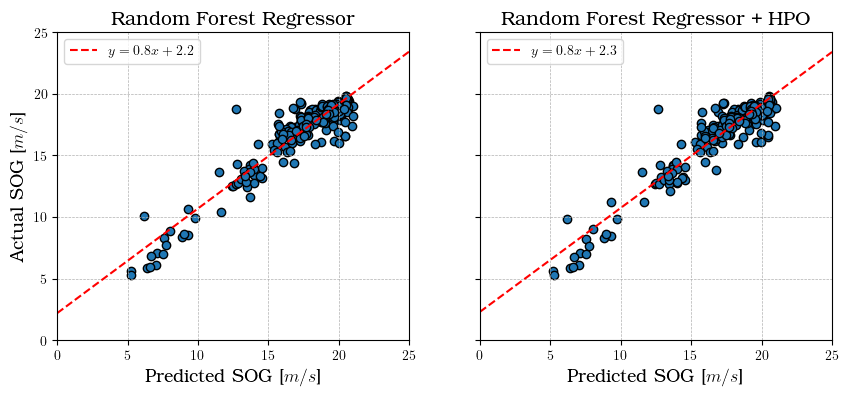

In [129]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_rfr_ftr,'Random Forest Regressor',x_date,y_date)
plt.sca(axes[1])
pred_plot(model_rfr_hpov,'Random Forest Regressor + HPO',x_date,y_date)
plt.ylabel("")
plt.show()

0.8745598516545046
y = 0.85605 * x + 2.09901
0.8699717740444685
y = 0.83479 * x + 2.43534


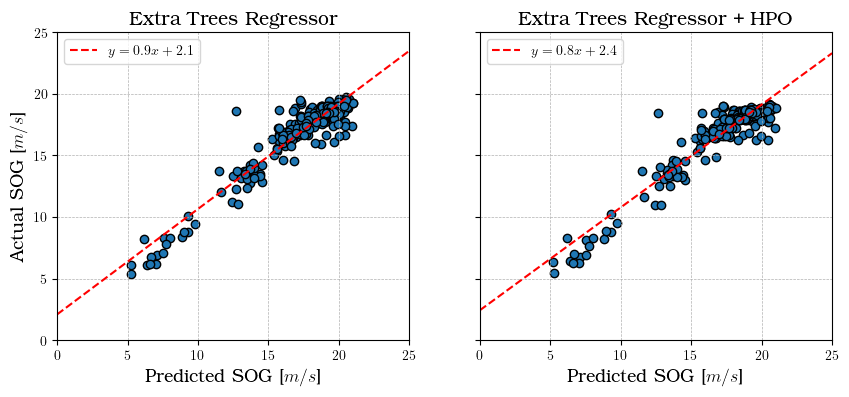

In [130]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_etr,'Extra Trees Regressor',x_date,y_date)
plt.sca(axes[1])
pred_plot(model_etr_hpov,'Extra Trees Regressor + HPO',x_date,y_date)
plt.ylabel("")
plt.show()

Evaluation using Cross Validation

In [ ]:
scores_test = [r2_rf,r2_et,r2_dt,r2_mlr]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title("Validation Data Model Performance")
plt.ylabel("R-squared")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(0.2,1.0)
plt.boxplot(scores_test,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['RFR', 'ETR',
                    'DTR','MLR'])
plt.show()

In [ ]:
scores_test = [-RMSE_rf,-RMSE_et,-RMSE_dt,-RMSE_mlr]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title("Validation Data Model Performance")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(0,1.6)
plt.boxplot(scores_test,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['RFR', 'ETR',
                    'DTR','MLR'])
plt.show()

Optimization comparison

In [ ]:
scores_opt = [r2_rf,r2_rfo,r2_et,r2_eto,r2_dt,r2_dto]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
fig,ax = plt.subplots() 
plt.title("Optimized Model on Test Dataset Performance")
plt.ylabel("R-squared")
plt.xlabel("Model")
plt.ylim(0.2,1.0)
plt.yscale('linear')
ax.boxplot(scores_opt,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels([r'RFR', r'$RFR_{opt}$',
                    r'ETR', r'$ETR_{opt}$',
                    r'DTR',r'$DTR_{opt}$'])
plt.show()

In [ ]:
rmse_opt = [-RMSE_rf,-RMSE_rfo,-RMSE_et,-RMSE_eto,-RMSE_dt,-RMSE_dto]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
fig,ax = plt.subplots() 
plt.title("Optimized Model Performance")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(1.6,0)
ax.boxplot(rmse_opt,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels([r'RFR', r'$RFR_{opt}$',
                    r'ETR', r'$ETR_{opt}$',
                    r'DTR',r'$DTR_{opt}$'])
plt.show()

In [ ]:
# define the true objective function
def objective(x, a, b, c):
	return a * x + b * x**2 + c

In [ ]:
# fit a second degree polynomial to the economic data
from numpy import arange
from scipy.optimize import curve_fit

plt.figure(figsize=(10,10))

# define the true objective function
def objective(x, a, b ):
	return a * x + b

def label_predict(model,test_features):
    predictions = model.predict(test_features)
    return predictions

y = label_predict(model_mlr_ftr,x_date)
y2 = label_predict(model_rfr_hpov,x_date)

from sklearn.metrics import r2_score

print(r2_score(y_date, y))
print(r2_score(y_date,y2))

# choose the input and output variables
x, y = y_date, y
x2, y2 = y_date, y2
# curve fit
popt, _ = curve_fit(objective, x, y)
popt2, _ = curve_fit(objective, x2, y2)

# summarize the parameter values
a, b = popt
print('y = %.5f * x + %.5f' % (a, b ))
a2, b2 = popt2
print('y = %.5f * x + %.5f' % (a2, b2))
# plot input vs output
plt.scatter(x, y)
plt.scatter(x2, y2)
# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 1)
x_line2 = arange(min(x), max(x), 1)
# calculate the output for the range
y_line = objective(x_line, a, b)
y_line2 = objective(x_line2, a2, b2)
# create a line plot for the mapping function
plt.plot(x_line, y_line, color='red')
plt	.plot(x_line2, y_line2, color='green')
plt.xlabel('STWpred', fontsize=15)
plt.ylabel('STWact', fontsize=15)
plt.show()

STW Calculation

In [ ]:
def label_predict(model,test_features):
    predictions = model.predict(test_features)
    return predictions

ydate_pred = label_predict(model_mlr_ftr,x_date)
 
dfprog_sog = pd.Series(y_date,name="sog_act").to_frame()
dfprog_sog["sog_pred"] = ydate_pred
dfprog_sog["gamma"] = dfdate6tr["truenorthcurrentdir"]
dfprog_sog["nwinddir"] = dfdate6tr["truenorthwinddir"]

print(dfprog_sog)

In [ ]:
dfprog = pd.concat([x_date,dfprog_sog],axis=1)
dfprog.head(n=10)

In [ ]:
# Conversion of predicted SOG to m/s

dfprog["vgms"] = dfprog["sog_pred"]/1.9438

# Conversion of actual SOG to m/s

dfprog["vgms_act"] = dfprog["sog_act"]/1.9438

In [ ]:
# Conversion of the angles to radian

rad_gamma = np.deg2rad(dfprog["gamma"])
rad_cog = np.deg2rad(dfprog["cog"])

In [ ]:
# Calculation of the predicted x-component of SOG

dfprog["vgx"] = dfprog["vgms"] * np.sin(rad_cog)
dfprog["vcx"] = dfprog["curspeed"] * np.sin(rad_gamma)
dfprog["stw_x"] = (dfprog["vgx"] - dfprog["vcx"])

# Calculation of the actual x-component of SOG

dfprog["vgx_act"] = dfprog["vgms_act"] * np.sin(rad_cog)
dfprog["stw_x_act"] = (dfprog["vgx_act"] - dfprog["vcx"])


In [ ]:
# Calculation of the predicted y-component of SOG 

dfprog["vgy"] = dfprog["vgms"] * np.cos(rad_cog)
dfprog["vcy"] = dfprog["curspeed"] * np.cos(rad_gamma)
dfprog["stw_y"] = (dfprog["vgy"] - dfprog["vcy"])

# Calculation of the actual y-component of SOG

dfprog["vgy_act"] = dfprog["vgms_act"] * np.cos(rad_cog)
dfprog["stw_y_act"] = (dfprog["vgy_act"] - dfprog["vcy"])


In [ ]:
# For the actual data
dfprog["vwms_a"] = np.sqrt(dfprog["stw_x_act"]**2 + dfprog["stw_y_act"]**2)
dfprog["stw_act"] = dfprog["vwms_a"]*1.9438

# For the prediction

dfprog["vwms_p"] = np.sqrt(dfprog["stw_x"]**2 + dfprog["stw_y"]**2)
dfprog["stw_pred"] = dfprog["vwms_p"]*1.9438



In [ ]:
dfprog = dfprog.drop(['vgms','vgx','vcx','stw_x',
                      'vgy','vcy','stw_y',
                      'vgms_act','vgx_act','stw_x_act',
                      'vgy_act','stw_y_act',
                      'vwms_p','vwms_a'],axis=1)
#df_ship.head(n=5)
dfprog.head(n=10)

In [ ]:
dfprog.describe()

In [ ]:
# FOC in T/d
dfprog["foc_act_d"] = ((dfprog["stw_act"]/17.7)**3) * 21.14112
dfprog["foc_pred_d"] = ((dfprog["stw_pred"]/17.7)**3) * 21.14112

# FOC in T/h
dfprog["foc_act_h"] = ((dfprog["stw_act"]/17.7)**3) * 0.8808
dfprog["foc_pred_h"] = ((dfprog["stw_pred"]/17.7)**3) * 0.8808

In [ ]:
dfprog.head(n=10)

In [ ]:
# df_foc=dfprog.drop(['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod',
#                     'surftemp','windwaveswellheight','swellheight','windwaveheight','swellheight',
#                     'windwaveheight','draught','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir',
#                     'truewavedir','gamma','nwinddir'],axis=1)

df_foc=dfprog.drop(['oceantemperature','waveperiod',
                    'surftemp','windwaveswellheight',
                    'draught','cog','heading','windspeed','curspeed',
                    'truewavedir'],axis=1)

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
df_foc.hist(bins=50,figsize=(20,15))
plt.show()

In [ ]:
foc_month = dfprog['foc_pred_d'].mean()
foc_month_a = dfprog['foc_act_d'].mean()
print(f"Mean of predicted FOC in a month is {foc_month} T/d")
print(f"Mean of actual FOC in a month is {foc_month_a} T/d")

In [ ]:
foc_trip = dfprog['foc_pred_h'].mean() * 4
foc_trip_a = dfprog['foc_act_h'].mean() * 4
foc_trip_err = foc_trip_a - foc_trip
print(f"Mean of predicted FOC in a 4h trip is {foc_trip} T")
print(f"Mean of actual FOC in a trip in a 4h trip is {foc_trip_a} T")
print(f"Error is {foc_trip_err} T")

In [ ]:
# plt.figure(figsize=(10,10))
# plt.scatter(dfprog['stw_pred'], dfprog['stw_act'], c='crimson')
# # plt.yscale('log')
# # plt.xscale('log')

# p1 = max(max(dfprog['stw_pred']), max(dfprog['stw_act']))
# p2 = min(min(dfprog['stw_pred']), min(dfprog['stw_act']))
# plt.plot([p1, p2], [p1, p2], 'b-')
# # plt.xscale('linear')
# plt.xlim(0,25)
# plt.ylim(0,30)
# plt.xlabel('STW', fontsize=15)
# plt.ylabel('FOC', fontsize=15)
# # plt.axis('equal')
# plt.show()

In [ ]:
# define the true objective function
def objective(x, a, b, c):
	return a * x + b * x**2 + c

In [ ]:
# fit a second degree polynomial to the economic data
from numpy import arange
from scipy.optimize import curve_fit

plt.figure(figsize=(10,10))

# define the true objective function
def objective(x, a, b ):
	return a * x + b

# choose the input and output variables
x, y = dfprog.stw_pred, dfprog.stw_act
# x2, y2 = dfprog.stw_pred, dfprog.foc_pred_d
# curve fit
popt, _ = curve_fit(objective, x, y)
# popt2, _ = curve_fit(objective, x2, y2)

# summarize the parameter values
a, b = popt
print('y = %.5f * x + %.5f' % (a, b ))
# a2, b2, c2 = popt2
# print('y = %.5f * x + %.5f * x^2 + %.5f' % (a2, b2, c2))
# plot input vs output
plt.scatter(x, y)
# plt.scatter(x2, y2)
# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 1)
# x_line2 = arange(min(x), max(x), 1)
# calculate the output for the range
y_line = objective(x_line, a, b)
# y_line2 = objective(x_line2, a2, b2, c2)
# create a line plot for the mapping function
plt.plot(x_line, y_line, color='red')
# plt	.plot(x_line2, y_line2, color='green')
plt.xlabel('STWpred', fontsize=15)
plt.ylabel('STWact', fontsize=15)
plt.show()

y = 1.06917 * x + -0.72944

linear y = 0.96885 * x + 0.96831

